# Out Paint

In [1]:
from keras.layers.convolutional import Conv2D, AtrousConvolution2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D
from keras_contrib.layers.normalization import InstanceNormalization
import keras.backend as K
import tensorflow as tf

import os
import numpy as np
import PIL
import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
from dataloader import Data, TestData

Using TensorFlow backend.


In [2]:
# Initialize dataloader
data = Data()
test_data = Data()

In [3]:
# Saves Model in every N minutes
TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 256, 3)
EPOCHS = 500
BATCH = 1

# 25% i.e 64 width size will be mask from both side
MASK_PERCENTAGE = .25

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "checkpoint/"
SAVED_IMAGES = "saved_images/"

## Models

### Discriminator

In [4]:
def root_mean_squared_error(y_true, y_pred):
    return -tf.reduce_mean(tf.log(tf.maximum(y_true, EPSILON)) + tf.log(tf.maximum(1. - y_pred, EPSILON)))

d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = Adam(0.0001, 0.5)

In [5]:
def d_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=d_dropout, norm=True):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def build_discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build_conv(d_input, 32, 5,strides=2, norm=False)

    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    
    flat = Flatten()(d)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)
    
    return Model(d_input, d_output)

In [6]:
# Discriminator initialization
DCRM = build_discriminator()
DCRM.compile(loss=root_mean_squared_error, optimizer=DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 32)       2432      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 64, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 64)        51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 32, 64)        0         
__________

### Generator Model

In [7]:
def gen_loss(y_true, y_pred):
    G_MSE_loss = K.mean(K.square(y_pred - y_true))
    return G_MSE_loss - ALPHA * tf.reduce_mean(tf.log(tf.maximum(y_pred, EPSILON)))

g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = Adam(0.001, 0.5)

In [8]:
def g_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=g_dropout, norm='inst', dilation=1):
    c = AtrousConvolution2D(filter_size, kernel_size=kernel_size, strides=strides,atrous_rate=(dilation,dilation), padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = ReLU()(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d


def build_generator():
    g_input = Input(shape=g_input_shape)
    
    g1 = g_build_conv(g_input, 64, 5, strides=1)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 256, 4, strides=2)

    g4 = g_build_conv(g3, 512, 4, strides=1)
    g5 = g_build_conv(g4, 512, 4, strides=1)
    
    g6 = g_build_conv(g5, 512, 4, strides=1, dilation=2)
    g7 = g_build_conv(g6, 512, 4, strides=1, dilation=4)
    g8 = g_build_conv(g7, 512, 4, strides=1, dilation=8)
    g9 = g_build_conv(g8, 512, 4, strides=1, dilation=16)
    
    g10 = g_build_conv(g9, 512, 4, strides=1)
    g11 = g_build_conv(g10, 512, 4, strides=1)
    
    g12 = g_build_deconv(g11, 256, 4, strides=2)
    g13 = g_build_deconv(g12, 128, 4, strides=2)
    
    g14 = g_build_conv(g13, 128, 4, strides=1)
    g15 = g_build_conv(g14, 64, 4, strides=1)
    
    g_output = AtrousConvolution2D(3, kernel_size=4, strides=(1,1), activation='tanh',padding='same', atrous_rate=(1,1))(g15)
    
    return Model(g_input, g_output)

In [9]:
# Generator Initialization
GEN = build_generator()
GEN.compile(loss=gen_loss, optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()

/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:304: UserWarning: The `AtrousConvolution2D` layer  has been deprecated. Use instead the `Conv2D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution2D` layer '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 128, 64)      4864      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 128, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256, 128, 64)      0         
_________________________________________________________________
instance_normalization_1 (In (None, 256, 128, 64)      2         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 64, 128)      131200    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128, 64, 128)      0         
__________

### Combined Model

In [10]:
IMAGE = Input(shape=g_input_shape)
DCRM.trainable = False
GENERATED_IMAGE = GEN(IMAGE)
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

### Masking and De-Masking

In [11]:
def mask_width(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:, new_width:]
    return image, missing_part


def get_masked_images(images):
    mask_images = []
    missing_images = []
    for image in images:
        mask_image, missing_image = mask_width(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images), np.array(missing_images)


def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

After masking
	Original Image			 a 		 b


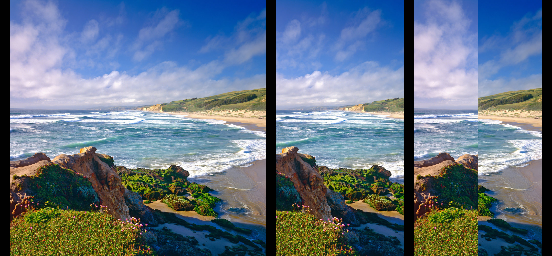

After desmasking: 'b/2' + a + 'b/2' 


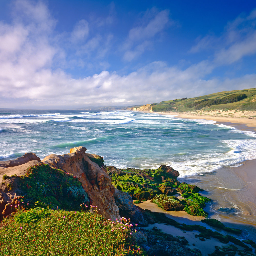

In [15]:
# Masking, Demasking example
# Note: IPython display gives false colors.
x = data.get_data(1)

# a will be the input and b will be the output for the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0],border,a[0],border, b[0], border), axis=1)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(c[0], cv2.COLOR_BGR2RGB)))

### Utilities
1. Save Model
2. Load Model
3. Save Image
4. Save Log

In [ ]:
def save_model():
    global DCRM, GEN
    models = [DCRM, GEN]
    model_names = ['DCRM','GEN']

    for model, model_name in zip(models, model_names):
        model_path =  CHECKPOINT + "%s.json" % model_name
        weights_path = CHECKPOINT + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Saved Model")
    
    
def load_model():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        DCRM = model_from_json(f.read())
    DCRM.load_weights(weight_path)
    DCRM.compile(loss='mse', optimizer=DCRM_OPTIMIZER)
    
    #load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
         GEN = model_from_json(f.read())
    GEN.load_weights(weight_path)
    
    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)
    
    print("loaded model")
    
    
def save_image(epoch, steps):
    train_image = test_data.get_data(1)
    if train_image is None:
        train_image = test_data.get_data(1)
        
    test_image = data.get_data(1)
    if test_image is None:
        test_image = test_data.get_data(1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
        mask_image_original , missing_image = get_masked_images(original)
        mask_image = mask_image_original.copy()
        mask_image = mask_image / 127.5 - 1
        missing_image = missing_image / 127.5 - 1
        gen_missing = GEN.predict(mask_image)
        gen_missing = (gen_missing + 1) * 127.5
        gen_missing = gen_missing.astype(np.uint8)
        demask_image = get_demask_images(mask_image_original, gen_missing)

        mask_image = (mask_image + 1) * 127.5
        mask_image = mask_image.astype(np.uint8)

        border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)

        file_name = str(epoch) + "_" + str(steps) + ".jpg"
        final_image = np.concatenate((border, original[0],border,mask_image_original[0],border, demask_image[0], border), axis=1)
        if not nc:
            cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        print("\t1.Original image \t 2.Input \t\t 3. Output")
        IPython.display.display(PIL.Image.fromarray(final_image))
        print("image saved")


def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

## Train

In [ ]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    global MIN_D_LOSS, MIN_G_LOSS, CURRENT_D_LOSS, CURRENT_G_LOSS
    for epoch in range(1, EPOCHS):
        steps = 1
        test = None
        while True:
            original = data.get_data(BATCH)
            if original is None:
                break
            batch_size = original.shape[0]

            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1

            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVALS * 60):
                save_model()
                save_image(epoch, steps)
                saved_time = current_time
        clear_output()
        

In [ ]:
load_model()

In [ ]:
train()

## Recursive paint

In [ ]:
load_model()

In [ ]:
def recursive_paint(image, factor=3):
    final_image = None
    gen_missing = None
    for i in range(factor):
        demask_image = None
        if i == 0:
            x, y = get_masked_images([image])
            gen_missing = GEN.predict(x)
            final_image = get_demask_images(x, gen_missing)[0]
        else:
            gen_missing = GEN.predict(gen_missing)
            final_image = get_demask_images([final_image], gen_missing)[0]
    return final_image
        

In [ ]:
images = data.get_data(1)
for i, image in enumerate(images):
    image = image / 127.5 - 1
    image = recursive_paint(image)
    image = (image + 1) * 127.5
    image = image.astype(np.uint8)
    path = 'recursive/'+str(i)+'.jpg'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    IPython.display.display(PIL.Image.fromarray(image))

## Test from URL

In [ ]:
url = 'https://i.pinimg.com/originals/9e/e5/20/9ee520cbece8b98dd1630f126525e43c.jpg'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)